In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Colab file upload
from google.colab import files
print("Upload an image (any format). It will be read as grayscale.")
up = files.upload()
assert len(up) > 0, "No file uploaded!"


fname = next(iter(up))
img_gray = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
if img_gray is None:
    img_gray = cv2.imdecode(np.frombuffer(up[fname], np.uint8), cv2.IMREAD_GRAYSCALE)

assert img_gray is not None, "Failed to read image."
print("Image shape:", img_gray.shape)


Upload an image (any format). It will be read as grayscale.


Saving image.png to image.png
Image shape: (569, 960)


In [2]:
# ---- Cell 2 ----
img_gray_f32 = img_gray.astype(np.float32)

# Gaussian noise params
mean, var = 0.0, 0.01
sigma = var ** 0.5

row, col = img_gray.shape
gauss = np.random.normal(mean, sigma, (row, col)).astype(np.float32)

# Add noise and clip
noisy_img = img_gray_f32 + gauss * 255.0
noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)

# Keep originals for plotting set
img_set = [img_gray, noisy_img]
img_title = ["Original", "Gaussian Noise"]


In [3]:

avg_filter = (1/9.0) * np.array([[1,1,1],
                                 [1,1,1],
                                 [1,1,1]], dtype=np.float32)

sobel_x = np.array([[-1,0,1],
                    [-2,0,2],
                    [-1,0,1]], dtype=np.float32)
sobel_y = np.array([[-1,-2,-1],
                    [ 0, 0, 0],
                    [ 1, 2, 1]], dtype=np.float32)

prewitt_x = np.array([[-1,0,1],
                      [-1,0,1],
                      [-1,0,1]], dtype=np.float32)
prewitt_y = np.array([[-1,-1,-1],
                      [ 0, 0, 0],
                      [ 1, 1, 1]], dtype=np.float32)

laplace_4 = np.array([[ 0,-1, 0],
                      [-1, 4,-1],
                      [ 0,-1, 0]], dtype=np.float32)

scharr_x = np.array([[-3, 0, 3],
                     [-10,0,10],
                     [-3, 0, 3]], dtype=np.float32)
scharr_y = np.array([[-3,-10,-3],
                     [ 0,  0, 0],
                     [ 3, 10, 3]], dtype=np.float32)

# ---- Custom kernels (4 + 1 extra = 5 total) ----
custom_checker = np.array([[ 1,-1, 1],
                           [-1, 0,-1],
                           [ 1,-1, 1]], dtype=np.float32)
custom_ridge_v = np.array([[-1],[2],[0],[2],[-1]], dtype=np.float32)  # 5x1
custom_corner = np.array([[ 2,-1, 2],
                          [-1,-2,-1],
                          [ 2,-1, 2]], dtype=np.float32)
custom_asym = np.array([[-1, 0, 1],
                        [-1, 1, 1],
                        [-1, 0, 1]], dtype=np.float32)
random_kernel = np.array([[ 2,-1,-1],
                          [-1, 2,-1],
                          [-1,-1, 2]], dtype=np.float32)

filters = {
    "Avg": avg_filter,
    "Sobel-X": sobel_x, "Sobel-Y": sobel_y,
    "Prewitt-X": prewitt_x, "Prewitt-Y": prewitt_y,
    "Scharr-X": scharr_x, "Scharr-Y": scharr_y,
    "Laplace-4": laplace_4,
    "Custom-Checker": custom_checker,
    "Custom-Ridge-V": custom_ridge_v,
    "Custom-Corner": custom_corner,
    "Custom-Asym": custom_asym,
    "Random-kernel": random_kernel
}


In [4]:


use_abs = True
noisy_f32 = noisy_img.astype(np.float32)
H, W = noisy_f32.shape


In [5]:

for name, k in filters.items():
    k = k.astype(np.float32)
    kh, kw = k.shape

    ph, pw = kh // 2, kw // 2
    padded = np.pad(noisy_f32, ((ph, ph), (pw, pw)), mode='reflect')
    out_same = np.zeros((H, W), dtype=np.float32)

    # Slide window
    for i in range(H):
        ii = i  # top-left in padded
        for j in range(W):
            jj = j
            roi = padded[ii:ii+kh, jj:jj+kw]
            out_same[i, j] = np.sum(roi * k)

    # Visualization (abs + min-max normalization 0..255)
    vis_same = out_same.copy()
    if use_abs:
        vis_same = np.abs(vis_same)
    mn, mx = float(vis_same.min()), float(vis_same.max())
    if mx - mn < 1e-9:
        vis_same = np.zeros_like(vis_same, dtype=np.uint8)
    else:
        vis_same = ((vis_same - mn) / (mx - mn) * 255.0)
        vis_same = np.clip(vis_same, 0, 255).astype(np.uint8)

    img_set.append(vis_same)
    img_title.append(f"{name} (same)")

    # ------------- VALID -------------
    out_h, out_w = H - kh + 1, W - kw + 1
    if out_h > 0 and out_w > 0:
        out_valid = np.zeros((out_h, out_w), dtype=np.float32)
        for i in range(out_h):
            for j in range(out_w):
                roi = noisy_f32[i:i+kh, j:j+kw]
                out_valid[i, j] = np.sum(roi * k)

        vis_valid = out_valid.copy()
        if use_abs:
            vis_valid = np.abs(vis_valid)
        mn, mx = float(vis_valid.min()), float(vis_valid.max())
        if mx - mn < 1e-9:
            vis_valid = np.zeros_like(vis_valid, dtype=np.uint8)
        else:
            vis_valid = ((vis_valid - mn) / (mx - mn) * 255.0)
            vis_valid = np.clip(vis_valid, 0, 255).astype(np.uint8)

        img_set.append(vis_valid)
        img_title.append(f"{name} (valid)")
    else:
        # Kernel is larger than image; skip valid
        pass


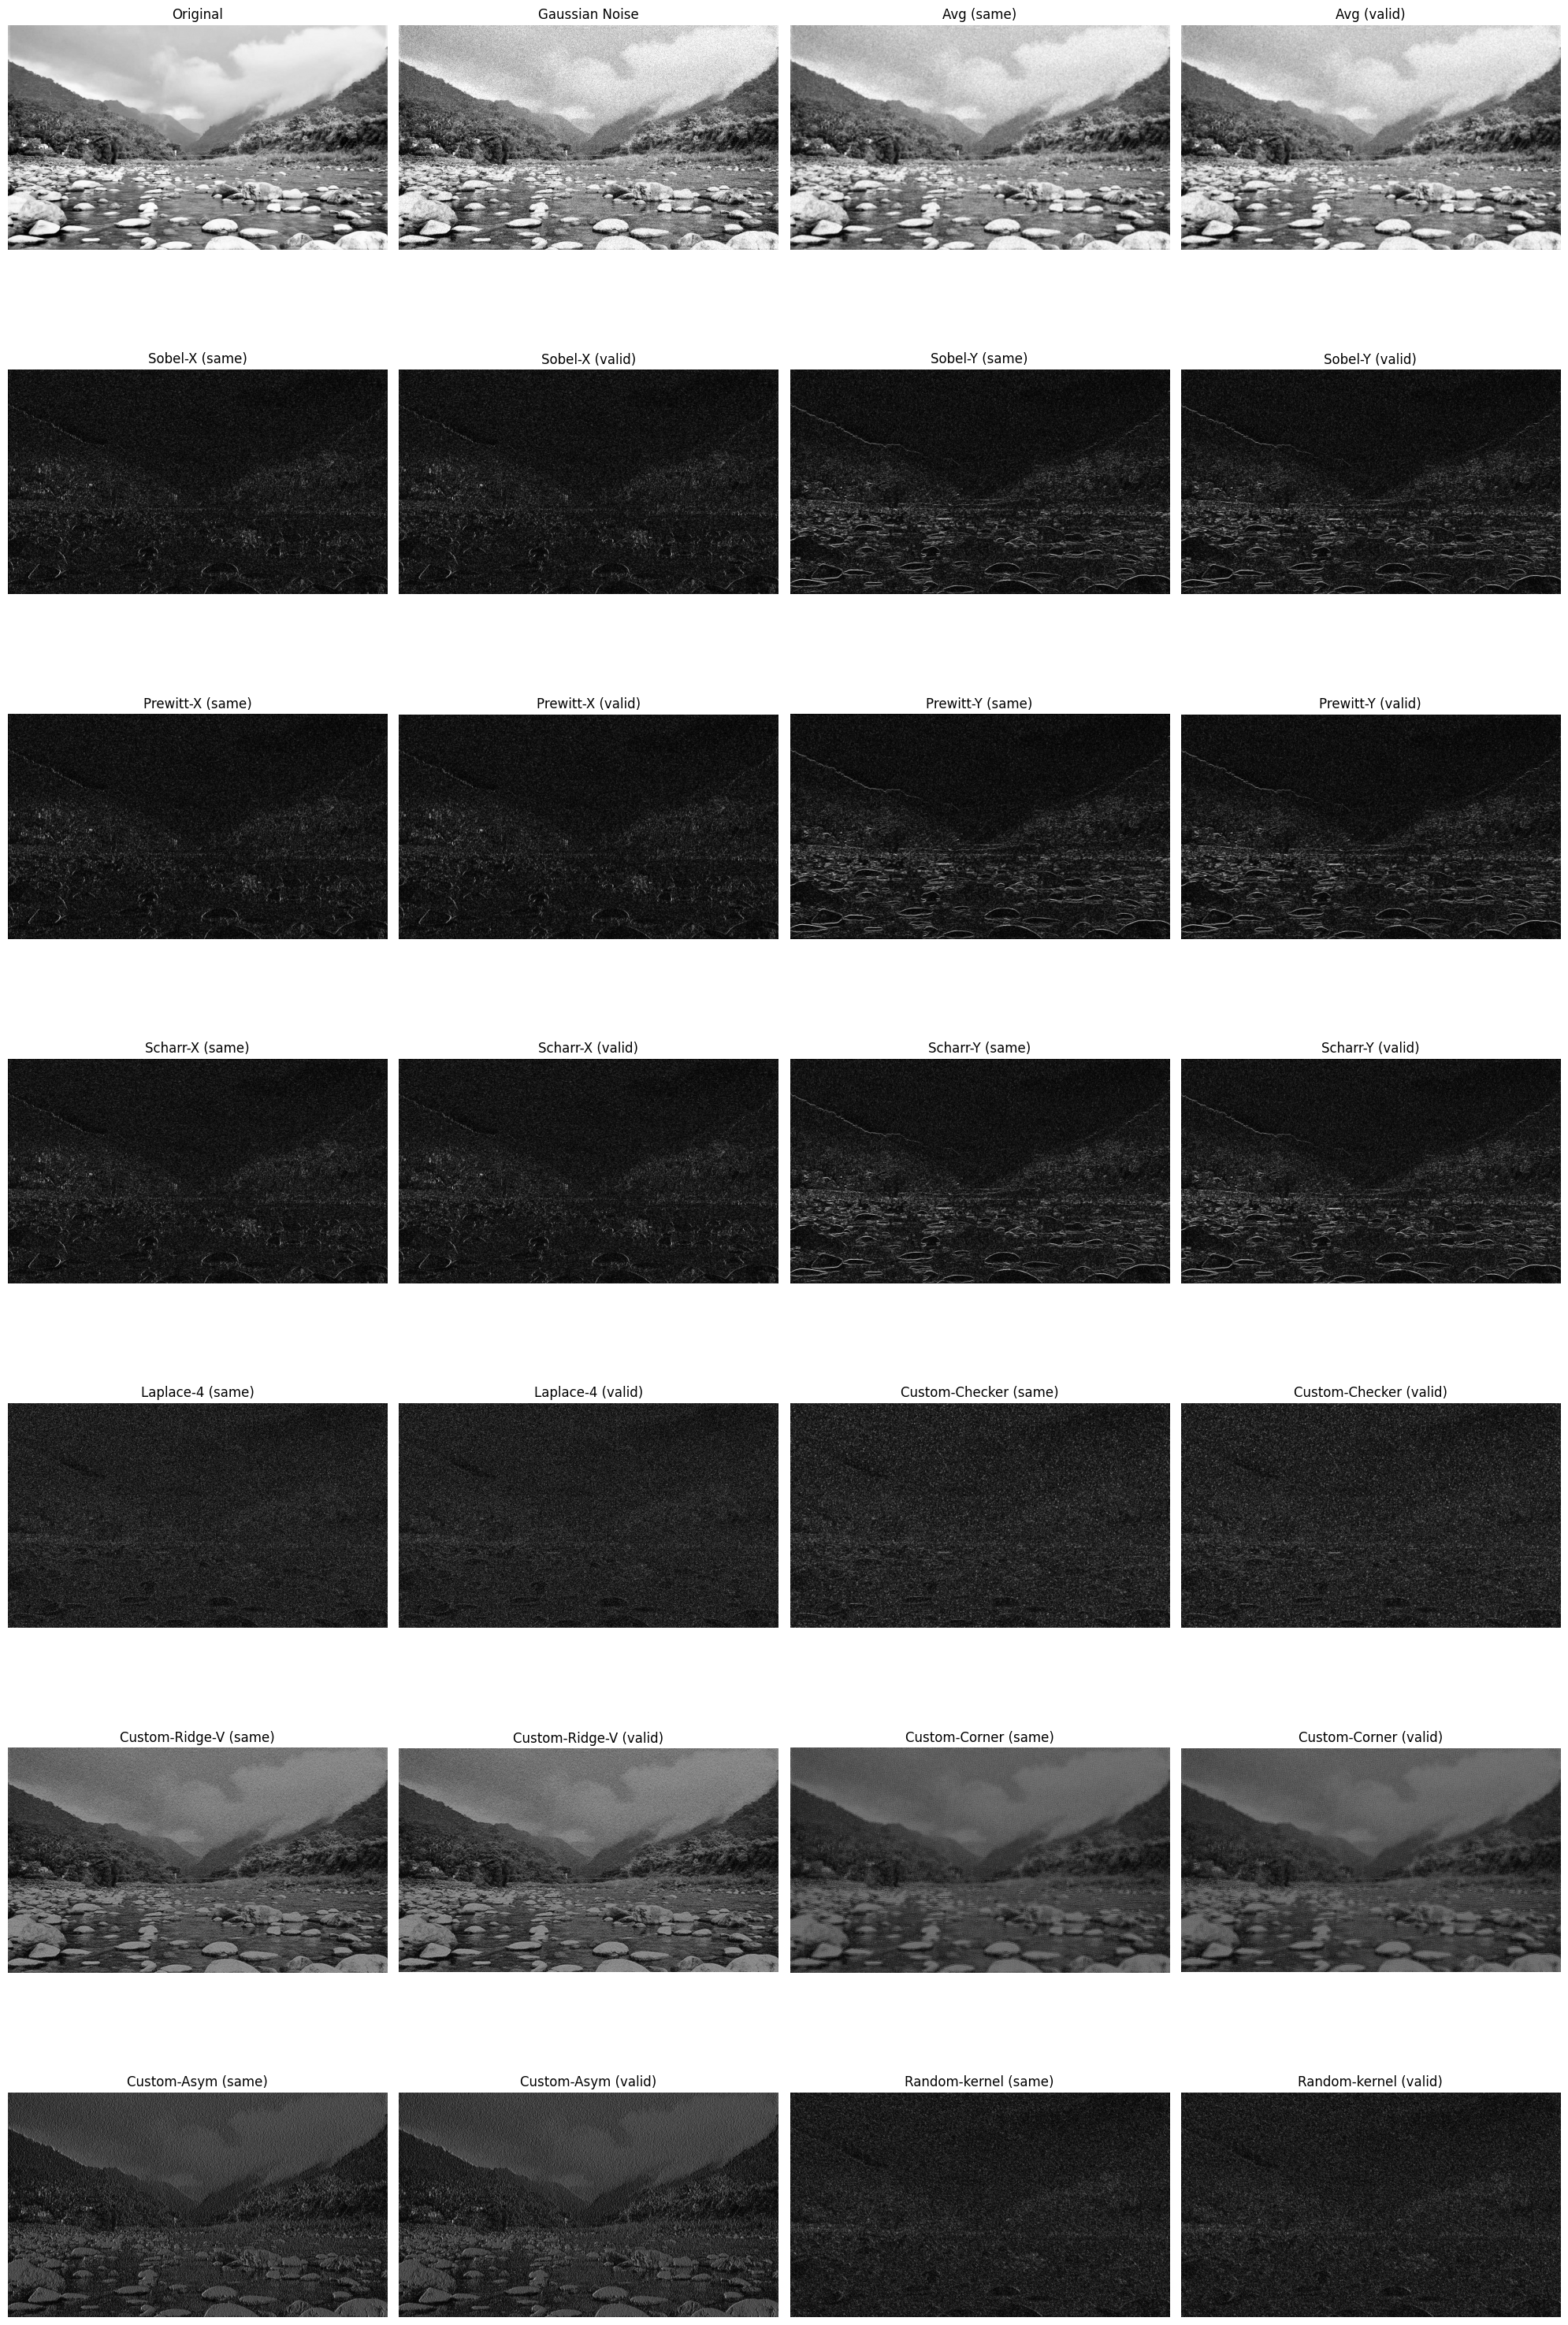

In [6]:

cols = 4
n = len(img_set)
rows = (n + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4.5 * rows))
for idx in range(n):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_set[idx], cmap='gray')
    plt.title(img_title[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()
